So you have a catalog, huh? And you also have some images, huh? Maybe you want to examine them!

TODO:
    - [ ] explain what each parameter means HERE

In [1]:
%matplotlib inline
from scipy.ndimage import imread
import pandas as pd
from ast import literal_eval

from IPython.html.widgets import interact
import mpld3
mpld3.enable_notebook()

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
field_directory = '/Users/cpd/Desktop/test/fields/'
cluster_directory = '/Users/cpd/Desktop/test/clusters/'
augmented_directory = '/Users/cpd/Desktop/test/augmented/'
catalog_path = cluster_directory + 'catalog.csv'
augmented_catalog_path = augmented_directory + 'augmented_catalog.csv'
knownlens_path = '/Users/cpd/Projects/strongcnn/catalog/knownlens.csv'
collection_path = '/Users/cpd/Google Drive/cs231n/annotated_catalog.csv'

In [43]:
# run create catalog code. This can take a while.
from subprocess import call
command = ['python', './create_catalogs.py',
           '--collection', collection_path,
           #'--knownlens', knownlens_path,
           '--clusters', cluster_directory,
           '--fields', field_directory,
           #'--augment', augmented_directory,
           #'--do_a_few', '100',
           ]
call(command)

0

In [44]:
if '.pickle' in collection_path:
    from create_catalogs import convert_swap_collection_to_dataframe
    # will need PJM's swap to interpret the spacewarps database
    try:
        import swap
    except:
        raise Exception('create_catalogs: Unable to import SpaceWarps analysis code!')

    #collection_path = base_collection_path + 'stage{0}'.format(stage) + '/CFHTLS_collection.pickle'
    collection_pickle = swap.read_pickle(collection_path, 'collection')
    stage = -1
    collection = convert_swap_collection_to_dataframe(collection_pickle, stage)
else:
    annotated_catalog = pd.read_csv(collection_path)
cluster_catalog = pd.read_csv(catalog_path)
# augmented_catalog = pd.read_csv(augmented_catalog_path)

In [45]:
print(cluster_catalog.columns)

Index([u'Unnamed: 0', u'ID', u'ZooID', u'location', u'mean_probability', u'category', u'kind', u'flavor', u'state', u'status', u'truth', u'stage', u'cluster_id', u'x', u'y', u'num_markers', u'skill_sum', u'tot_markers', u'cluster_marked_looks', u'total_marked_looks', u'total_looks', u'dispersion', u'field_name', u'cluster_name', u'cluster_type'], dtype='object')


In [46]:
# let's look at the known lens category of cutouts!
catalog = cluster_catalog[cluster_catalog['cluster_type'] == 'known lens']
catalog = cluster_catalog[(cluster_catalog['cluster_type'] == 'known lens') & (cluster_catalog['flavor'] == 'test')]

blurb describing examine catalog function

In [47]:
def examine_catalog(catalog):
    def examine_cat(groupby_str):
        groupby_list = eval(groupby_str)
        print(catalog.groupby(groupby_list).apply(len))
        
    interact(examine_cat,
             groupby_str="['stage', 'flavor', 'cluster_type']")
examine_catalog(catalog)

Empty DataFrame
Columns: []
Index: []


If you don't have the annotated catalog, then you don't need to provide it to examine individual images. Of course, then the 'show_field' option will throw an error if marked True.

In [37]:
from create_catalogs import outlier_clusters_dbscan
from IPython.display import display

def examine_cutouts(catalog, cluster_directory, annotated_catalog=None, field_directory=None,
                    plot_alpha=False, invert_color=False, color_by_user=False, plot_points=True):
    # some generic things you can configure:
    # what columns we want to plot

    if 'augment_type' in catalog.columns:
        columns = ['ZooID', 'cluster_id', 'stamp_id', 'stage', 'flavor', 'cluster_type', 'status',
                   'num_markers', 'tot_markers', 'cluster_marked_looks', 'total_marked_looks', 'total_looks', 
                   'dispersion', 'mean_probability', 'x', 'y', 'augment_type']
        augmented = True
    else:
        columns = ['ZooID', 'cluster_id', 'stage', 'flavor', 'cluster_type', 'status',
                   'num_markers', 'tot_markers', 'cluster_marked_looks', 'total_marked_looks', 'total_looks', 
                   'dispersion', 'mean_probability', 'x', 'y']
        augmented = False        
#     # by default the annotated image colors by group.
#     # we could color by user instead
#     color_by_user=False
#     # training images have an alpha layer. this is useful
#     # for debugging whether or not a training image was
#     # properly classified
#     plot_alpha=False
#     # sometimes it's really hard to see the tooltips since
#     # they are black and I have no idea how to change the color
#     invert_color=False
#     # for when you just want to see the field
#     plot_points=True
    def examine_entry(i, show_field=False):
        entry = catalog.iloc[i]
        ZooID = entry['ZooID']
        entry = catalog.iloc[i]
        display(entry[columns])

        if augmented:
            cluster_path = augmented_directory + entry['stamp_name']
        else:
            cluster_path = cluster_directory + entry['cluster_name']
        
        cluster = imread(cluster_path) * 1. / 255.
        if invert_color:
            cluster = np.abs(cluster - cluster.max())
        
        if show_field:
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
            axs[0].imshow(cluster)
            cat = annotated_catalog.set_index(['ZooID'])

            entry = cat.loc[ZooID]


            if plot_points:
                x_unflat = literal_eval(entry['At_X'])
                y_unflat = literal_eval(entry['At_Y'])
                # flatten out x and y. also cut out empty entries
                x = np.array([xi for xj in x_unflat for xi in xj])
                y = np.array([yi for yj in y_unflat for yi in yj])

                users = np.array([xj for xj in xrange(len(x_unflat)) for xi in x_unflat[xj]])
                binusers = np.bincount(users)
                w = 1. / binusers[users]

                cluster_centers, cluster_labels, labels = outlier_clusters_dbscan(x, y, w=w)
                if color_by_user:
                    c = users
                else:
                    c = labels
                points = axs[1].scatter(x, y, c=c, s=50, alpha=0.8, cmap=plt.cm.Accent)
                tooltiplabels = ['({0}, {1}, {2})'.format(labels[i], users[i], w[i]) for i in xrange(len(labels))]
                tooltip = mpld3.plugins.PointLabelTooltip(points, tooltiplabels)
                mpld3.plugins.connect(fig, tooltip)

            field = imread(field_directory + ZooID + '.png') * 1. / 255. #entry['ZooID'] + '.png')
            if plot_alpha:
                if np.shape(field)[-1] == 4:
                    field = field[:, :, 3]
            else:
                field = field[:, :, :3]
            if invert_color:
                field = np.abs(field - field.max())
            IM = axs[1].imshow(field)
            mpld3.plugins.connect(fig, mpld3.plugins.MousePosition(fontsize=14))
        else:
            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
            axs.imshow(cluster)
    
    interact(examine_entry,
             i=(0, len(catalog)-1),
             show_field=False)

In [35]:
len(cluster_catalog)

11512

ZooID                   ASW0001f97
cluster_id                     685
stage                            1
flavor                         dud
cluster_type                   dud
status                    rejected
num_markers                      3
tot_markers                      4
cluster_marked_looks             3
total_marked_looks               4
total_looks                    176
dispersion                 12.5666
mean_probability             2e-08
x                         349.4944
y                         350.8556
Name: 685, dtype: object

/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/sklearn/cluster/dbscan_.py:106: DeprecationWarning: The parameter random_state is deprecated in 0.16 and will be removed in version 0.18. DBSCAN is deterministic except for rare border cases.
  category=DeprecationWarning)


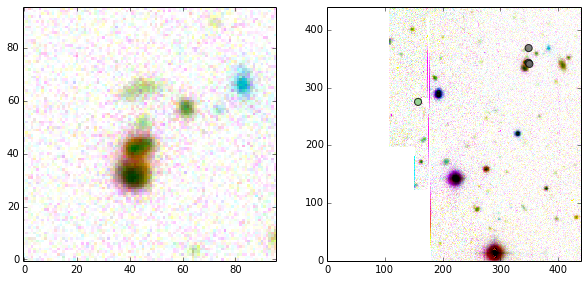

In [40]:
catalog = cluster_catalog[cluster_catalog['num_markers'] < 4]
examine_cutouts(catalog, cluster_directory, annotated_catalog, field_directory,
                plot_alpha=False, invert_color=True, color_by_user=False, plot_points=True)